In [18]:
%load_ext autoreload
%autoreload 2
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-864c07c4-8eeb-5b23-8d57-eaeb942a9a0f"
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from hydra.utils import instantiate
from PIL import Image
from torch.utils.data import DataLoader, Dataset

from br.features.archetype import AA_Fast
from br.features.plot import collect_outputs, plot, plot_stratified_pc
from br.features.reconstruction import stratified_latent_walk
from br.features.utils import (
    normalize_intensities_and_get_colormap,
    normalize_intensities_and_get_colormap_apply,
)
from br.models.compute_features import compute_features, get_embeddings
from br.models.load_models import get_data_and_models
from br.models.save_embeddings import (
    get_pc_loss,
    get_pc_loss_chamfer,
    save_embeddings,
    save_emissions,
)
from br.models.utils import get_all_configs_per_dataset

device = "cuda:0"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
os.chdir("/allen/aics/modeling/ritvik/projects/benchmarking_representations/")
save_path = "./test_npm1_save_embeddings/"

In [21]:
dataset_name = "npm1"
batch_size = 2
debug = False
results_path = "/allen/aics/modeling/ritvik/projects/benchmarking_representations/configs/results/"
data_list, all_models, run_names, model_sizes = get_data_and_models(
    dataset_name, batch_size, results_path, debug
)

# Compute embeddings and emissions

In [22]:
run_names

['SO3_pointcloud_SDF',
 'SO3_image_SDF',
 'SO3_image_seg',
 'Classical_image_SDF',
 'Classical_image_seg']

In [23]:
from br.models.save_embeddings import save_embeddings

splits_list = ["train","val", "test"]
meta_key = None
eval_scaled_img = [False] * 5

gt_mesh_dir = "/allen/aics/assay-dev/users/Alex/replearn/rep_paper/data/var_blobby_noalign/meshes"
gt_sampled_pts_dir = "/allen/aics/assay-dev/users/Alex/replearn/rep_paper/data/sampled_pcs/npm1_var_noalign_global/1_res/0"
gt_scale_factor_dict_path = "/allen/aics/assay-dev/users/Alex/replearn/rep_paper/data/npm1_var_scale_factor_32res_noalign_global.npz"

eval_scaled_img_params = [
    {
        "eval_scaled_img_model_type": "iae",
        "eval_scaled_img_resolution": 32,
        "gt_mesh_dir": gt_mesh_dir,
        "gt_scale_factor_dict_path": None,
        "gt_sampled_pts_dir": gt_sampled_pts_dir,
        "mesh_ext": "stl",
    },
    {
        "eval_scaled_img_model_type": "sdf",
        "eval_scaled_img_resolution": 32,
        "gt_mesh_dir": gt_mesh_dir,
        "gt_scale_factor_dict_path": gt_scale_factor_dict_path,
        "gt_sampled_pts_dir": None,
        "mesh_ext": "stl",
    },
    {
        "eval_scaled_img_model_type": "seg",
        "eval_scaled_img_resolution": 32,
        "gt_mesh_dir": gt_mesh_dir,
        "gt_scale_factor_dict_path": gt_scale_factor_dict_path,
        "gt_sampled_pts_dir": None,
        "mesh_ext": "stl",
    },
    {
        "eval_scaled_img_model_type": "sdf",
        "eval_scaled_img_resolution": 32,
        "gt_mesh_dir": gt_mesh_dir,
        "gt_scale_factor_dict_path": gt_scale_factor_dict_path,
        "gt_sampled_pts_dir": None,
        "mesh_ext": "stl",
    },
    {
        "eval_scaled_img_model_type": "seg",
        "eval_scaled_img_resolution": 32,
        "gt_mesh_dir": gt_mesh_dir,
        "gt_scale_factor_dict_path": gt_scale_factor_dict_path,
        "gt_sampled_pts_dir": None,
        "mesh_ext": "stl",
    },
]
loss_eval_list = [torch.nn.MSELoss(reduction="none")] * 5
sample_points_list = [False] * 5
skew_scale = None
save_embeddings(
    save_path,
    data_list,
    all_models,
    run_names,
    debug,
    splits_list,
    device,
    meta_key,
    loss_eval_list,
    sample_points_list,
    skew_scale,
    eval_scaled_img,
    eval_scaled_img_params,
)

Processing train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4267/4267 [1:35:59<00:00,  1.35s/it]


Processing val


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 754/754 [17:00<00:00,  1.35s/it]


Processing test


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 887/887 [20:00<00:00,  1.35s/it]


Processing train


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4267/4267 [21:39<00:00,  3.28it/s]


Processing val


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 754/754 [03:50<00:00,  3.27it/s]


Processing test


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 887/887 [04:30<00:00,  3.28it/s]


Processing train


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4267/4267 [21:39<00:00,  3.28it/s]


Processing val


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 754/754 [03:50<00:00,  3.27it/s]


Processing test


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 887/887 [04:30<00:00,  3.28it/s]


Processing train


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4267/4267 [02:47<00:00, 25.49it/s]


Processing val


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 754/754 [00:30<00:00, 25.04it/s]


Processing test


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 887/887 [00:35<00:00, 25.31it/s]


Processing train


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4267/4267 [02:46<00:00, 25.59it/s]


Processing val


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 754/754 [00:31<00:00, 23.87it/s]


Processing test


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 887/887 [00:36<00:00, 24.29it/s]


In [24]:
run_names

['SO3_pointcloud_SDF',
 'SO3_image_SDF',
 'SO3_image_seg',
 'Classical_image_SDF',
 'Classical_image_seg']

# Latent walks

In [167]:
# Load model and embeddings

run_names = ["SO3_pointcloud_SDF"]
DATASET_INFO = get_all_configs_per_dataset(results_path)
all_ret, df = get_embeddings(run_names, dataset_name, DATASET_INFO, save_path)
model = all_models[0]

1     6134
2     3261
3      998
4      351
5      201
6      170
7      159
8      123
9      113
10      83
11      72
12      47
13      41
14      30
15       9
16       8
18       6
17       6
24       1
0        1
Name: connectivity_cc_32res_global, dtype: int64

In [174]:
this_row = all_ret.loc[all_ret['CellId'] == 652484]
[i for i in this_row.columns if "connectivity" in i]

['STR_connectivity_cc',
 'STR_connectivity_cc_thresh',
 'connectivity_cc_32res_global',
 'connectivity_cc_64res',
 'connectivity_cc_thresh_32res',
 'connectivity_cc_thresh_32res_global',
 'dna_connectivity_number_cc',
 'mem_connectivity_number_cc',
 'str_connectivity_number_cc']

In [171]:
from sklearn.decomposition import PCA
from tqdm import tqdm
from cyto_dl.image.transforms import RotationMask
from skimage.io import imread
from br.data.utils import mesh_seg_model_output
import pyvista as pv
from br.visualization.mitsuba_render_image import plot

this_save_path = Path(save_path) / Path("latent_walks")
this_save_path.mkdir(parents=True, exist_ok=True)


for num_pieces in all_ret['STR_connectivity_cc_thresh'].unique():
    this_sub_m = all_ret.loc[all_ret['STR_connectivity_cc_thresh'] == num_pieces].reset_index(drop=True)
    all_features = this_sub_m[[i for i in this_sub_m.columns if "mu" in i]].values
    latent_dim=512
    dim_size = latent_dim
    x_label = 'pcloud'
    pca = PCA(n_components=dim_size)
    pca_features = pca.fit_transform(all_features)
    pca_std_list = pca_features.std(axis=0)
    for rank in [0, 1]:
        all_xhat = []
        all_closest_real = []
        all_closest_img = []
        latent_walk_range = [-2, 0, 2]
        for value_index, value in enumerate(
                tqdm(latent_walk_range, total=len(latent_walk_range))
            ):
            z_inf = torch.zeros(1, dim_size)
            z_inf[:, rank] += value * pca_std_list[rank]
            z_inf = pca.inverse_transform(z_inf).numpy()
        
            dist = (all_features - z_inf) ** 2
            dist = np.sum(dist, axis=1)
            closest_idx = np.argmin(dist)
            closest_real_id = this_sub_m.iloc[closest_idx]['CellId']
            mesh = pv.read(all_ret.loc[all_ret['CellId'] == closest_real_id]['mesh_path_noalign'].iloc[0])
            print(closest_real_id, num_pieces, rank, value_index)
            mesh.save(this_save_path / Path(f'{num_pieces}_{rank}_{value_index}.ply'))

            # this_mesh_path = this_save_path / Path(f'{num_pieces}_{rank}_{value_index}.ply')
            # this_mesh_path = './' + str(this_mesh_path)
            
            # mitsuba_save_path = this_save_path / Path('mitsuba')
            # mitsuba_save_path.mkdir(parents=True, exist_ok=True)
            # mitsuba_save_path = './' + str(mitsuba_save_path)
            # name = f"{num_pieces}_{rank}_{value_index}"
            
            # plot(str(this_mesh_path), mitsuba_save_path, 120, None, None, name)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.63it/s]


645372 2.0 0 0
979703 2.0 0 1
717376 2.0 0 2


 67%|████████████████████████████████████████████████████████████████████████████                                      | 2/3 [00:00<00:00, 13.97it/s]

668470 2.0 1 0
979703 2.0 1 1
718319 2.0 1 2


 33%|██████████████████████████████████████                                                                            | 1/3 [00:00<00:00,  9.26it/s]

989964 1.0 0 0
653131 1.0 0 1
704301 1.0 0 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.54it/s]

660108 1.0 1 0
653131 1.0 1 1
718317 1.0 1 2



 33%|██████████████████████████████████████                                                                            | 1/3 [00:00<00:00,  9.92it/s]

673280 3.0 0 0
726403 3.0 0 1
959106 3.0 0 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.24it/s]

652484 3.0 1 0
726403 3.0 1 1
645392 3.0 1 2



 67%|████████████████████████████████████████████████████████████████████████████                                      | 2/3 [00:00<00:00, 10.94it/s]

648712 >=5 0 0
687675 >=5 0 1
733524 >=5 0 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.73it/s]

728026 >=5 1 0
687675 >=5 1 1
973332 >=5 1 2



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.87it/s]


729612 4.0 0 0
709542 4.0 0 1
661632 4.0 0 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.62it/s]

682106 4.0 1 0
709542 4.0 1 1
712186 4.0 1 2


In [170]:
1

1

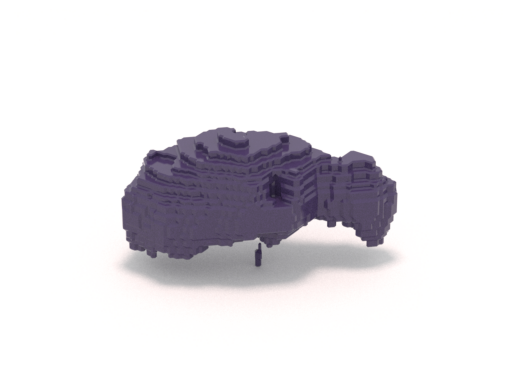

In [228]:
save_path = "./test_npm1_save_embeddings/"
this_save_path = Path(save_path) / Path("latent_walks")

# num_pieces = 4.0
num_pieces = "2.0"
rank = 0
bin_ = 0
this_mesh_path = this_save_path / Path(f'{num_pieces}_{rank}_{bin_}.ply')
this_mesh_path = './' + str(this_mesh_path)

save_path = this_save_path / Path('mitsuba')
save_path.mkdir(parents=True, exist_ok=True)
save_path = './' + str(save_path)
name = f"{num_pieces}_{rank}_{bin_}"


plot(str(this_mesh_path), save_path, 10, 0, None, name)

In [120]:
save_path

'./test_npm1_save_embeddings/latent_walks/mitsuba'

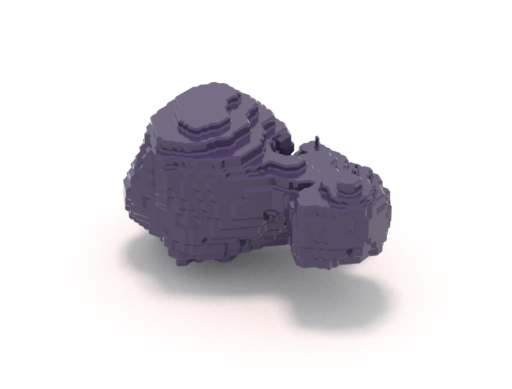

# Archetype

In [42]:
from br.features.archetype import AA_Fast
n_archetypes = 5
matrix = all_ret[[i for i in all_ret.columns if "mu" in i]].values
aa = AA_Fast(n_archetypes, max_iter=1000, tol=1e-6).fit(matrix)

import pandas as pd
archetypes_df = pd.DataFrame(aa.Z, columns = [f'mu_{i}' for i in range(matrix.shape[1])])

In [44]:
this_save_path = Path(save_path) / Path("archetypes")
this_save_path.mkdir(parents=True, exist_ok=True)

all_features =  matrix
for i in range(n_archetypes):
    this_mu = archetypes_df.iloc[i].values
    dist = (all_features - this_mu) ** 2
    dist = np.sum(dist, axis=1)
    closest_idx = np.argmin(dist)
    closest_real_id = all_ret.iloc[closest_idx]['CellId']
    print(dist, closest_real_id)
    mesh = pv.read(all_ret.loc[all_ret['CellId'] == closest_real_id]['mesh_path_noalign'].iloc[0])
    mesh.save(this_save_path / Path(f'{i}.ply'))
        

[0.11153081 0.16697131 0.22473612 ... 0.16851056 0.15113705 0.11090566] 680546
[0.15365319 0.15559438 0.16168012 ... 0.22011907 0.10088067 0.19161511] 692452
[0.10922213 0.08953973 0.08698778 ... 0.08301687 0.13738574 0.09462076] 676793
[0.1882512  0.11550001 0.27985373 ... 0.07323821 0.27115297 0.08720716] 691903
[0.17302999 0.13066942 0.15613681 ... 0.17994784 0.15923091 0.16836185] 652058


In [207]:
save_path

'./test_npm1_save_embeddings/latent_walks/mitsuba/archetypes/mitsuba'

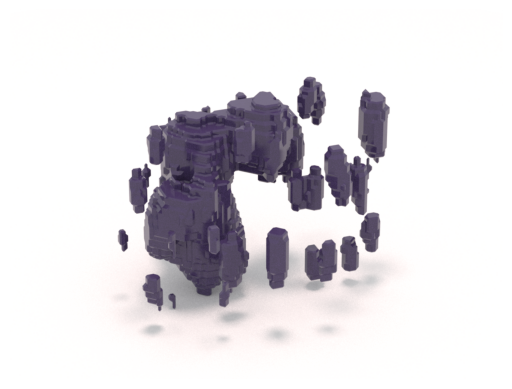

In [214]:
save_path = "./test_npm1_save_embeddings/"
this_save_path = Path(save_path) / Path("archetypes")

arch = "4"
this_mesh_path = this_save_path / Path(f'{arch}.ply')
this_mesh_path = './' + str(this_mesh_path)

save_path = this_save_path / Path('mitsuba')
save_path.mkdir(parents=True, exist_ok=True)
save_path = './' + str(save_path)
name = f"{arch}"


plot(str(this_mesh_path), save_path, 90, 0, None, name)

# Pseudo time

In [215]:
all_ret['volume_of_nucleus_um3'] = all_ret['dna_shape_volume_lcc']*0.108**3

In [216]:
feat = 'volume_of_nucleus_um3'
upper = np.quantile(all_ret[feat], q=0.99)
lower = np.quantile(all_ret[feat], q=0.01)

this = all_ret.loc[all_ret[feat] < upper]
this = this.loc[this[feat] > lower].reset_index(drop=True)

In [217]:
this['vol_bins'] = pd.cut(this[feat], bins=5)
this['vol_bins_ind'] = pd.factorize(this['vol_bins'])[0]

In [218]:
this['vol_bins'].value_counts()

(390.752, 533.383]    4268
(533.383, 676.015]    3530
(676.015, 818.646]    1797
(247.407, 390.752]    1373
(818.646, 961.277]     608
Name: vol_bins, dtype: int64

In [219]:
this_save_path = Path(save_path) / Path("pseudo_time")
this_save_path.mkdir(parents=True, exist_ok=True)

In [81]:
all_features = this[[i for i in this.columns if "mu" in i]].values
this['vol_bins'] = this['vol_bins'].astype(str)
for hh in this['vol_bins'].unique():
    this_ret = this.loc[this['vol_bins'] == hh].reset_index(drop=True)
    
    this_mu = np.expand_dims(this_ret[[i for i in this_ret.columns if "mu" in i]].mean(axis=0), axis=0)
    dist = (all_features - this_mu) ** 2
    # dist = np.sum(dist, axis=1)
    k = 2
    # print(min(latent_dim, all_features.shape[0]))
    inds = np.argpartition(dist.sum(axis=-1), k)[:k] # get 10 closest
    closest_samples = this.iloc[inds].reset_index(drop=True)
    for ind, row in closest_samples.iterrows():
        # closest_real_id = this.iloc[closest_idx]['CellId']
        closest_real_id = row['CellId']
        print(closest_idx, this_ret['vol_bins'].unique(), all_features.shape, this_ret.shape, this_ret['dna_shape_volume_lcc'].mean(), closest_real_id)
        mesh = pv.read(all_ret.loc[all_ret['CellId'] == closest_real_id]['mesh_path_noalign'].iloc[0])
        mesh.save(this_save_path / Path(f'{hh}_{ind}_{closest_real_id}.ply'))
        

560 ['(533.383, 676.015]'] (11576, 512) (3530, 868) 473565.02294617565 970952
560 ['(533.383, 676.015]'] (11576, 512) (3530, 868) 473565.02294617565 979703
560 ['(390.752, 533.383]'] (11576, 512) (4268, 868) 370138.02132146206 979703
560 ['(390.752, 533.383]'] (11576, 512) (4268, 868) 370138.02132146206 688059
560 ['(676.015, 818.646]'] (11576, 512) (1797, 868) 584521.938786867 688059
560 ['(676.015, 818.646]'] (11576, 512) (1797, 868) 584521.938786867 979703
560 ['(247.407, 390.752]'] (11576, 512) (1373, 868) 270939.49308084487 691568
560 ['(247.407, 390.752]'] (11576, 512) (1373, 868) 270939.49308084487 727462
560 ['(818.646, 961.277]'] (11576, 512) (608, 868) 693906.9358552631 710473
560 ['(818.646, 961.277]'] (11576, 512) (608, 868) 693906.9358552631 653131


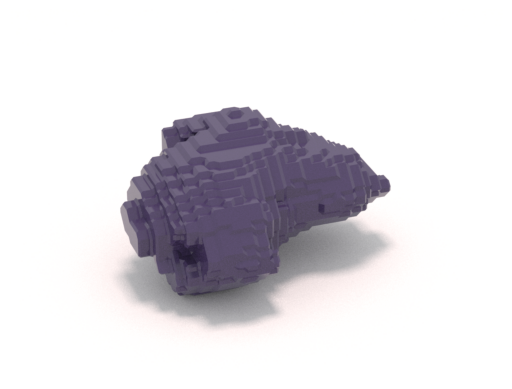

In [227]:
save_path = "./test_npm1_save_embeddings/"
this_save_path = Path(save_path) / Path("pseudo_time")

pseu = "(533.383, 676.015]_0_970952"
this_mesh_path = this_save_path / Path(f'{pseu}.ply')
this_mesh_path = './' + str(this_mesh_path)

save_path = this_save_path / Path('mitsuba')
save_path.mkdir(parents=True, exist_ok=True)
save_path = './' + str(save_path)
name = f"{pseu}"


plot(str(this_mesh_path), save_path, 90, 90, None, name)